# Simple guide to confusion matrix terminology
A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known. The confusion matrix itself is relatively simple to understand, but the related terminology can be confusing.

Let's start with an <b>example confusion matrix for a binary classifier</b> (though it can easily be extended to the case of more than two classes):

| n=165 | <b>Predicted: NO</b> | <b>Predicted: YES</b> |
| --- | --- | --- |
| <b>Actual: NO</b> | 50 | 10 |
| <b>Actual: YES</b> | 5 | 100 |

What can we learn from this matrix?
- There are two possible predicted classes: "yes" and "no". If we were predicting the presence of a disease, for example, "yes" would mean they have the disease, and "no" would mean they don't have the disease.
- The classifier made a total of 165 predictions (e.g., 165 patients were being tested for the presence of that disease).
- Out of those 165 cases, the classifier predicted "yes" 110 times, and "no" 55 times.
- In reality, 105 patients in the sample have the disease, and 60 patients do not.

Let's now define the most basic terms, which are whole numbers (not rates):
- True Positives (TP): These are cases in which we predicted yes (they have the disease), and they do have the disease.
- True Negatives (TN): We predicted no, and they don't have the disease.
- False Positives (FP): We predicted yes, but they don't actually have the disease. (Also known as a "Type I error.")
- False Negatives (FN): We predicted no, but they actually do have the disease. (Also known as a "Type II error.")

I've added these terms to the confusion matrix, and also added the row and column totals:

| n=165 | <b>Predicted: NO</b> | <b>Predicted: YES</b> | Total |
| --- | --- | --- | --- |
| <b>Actual: NO</b> | TN=50 | FP=10 | 60 |
| <b>Actual: YES</b> | FN=5 | TP=100 | 105|
| Total | 55 | 110 | |

This is a list of rates that are often computed from a confusion matrix for a binary classifier:
1. <b>Accuracy:</b> Overall, how often is the classifier correct?
    - (TP+TN)/total = (100+50)/165 = 0.91
2. <b>Misclassification Rate:</b> Overall, how often is it wrong?
    - (FP+FN)/total = (10+5)/165 = 0.09
    - equivalent to 1 minus Accuracy
    - also known as "Error Rate"
3. <b>True Positive Rate:</b> When it's actually yes, how often does it predict yes?
    - TP/actual yes = 100/105 = 0.95
    - also known as "Sensitivity" or "Recall"
4. <b>False Positive Rate:</b> When it's actually no, how often does it predict yes?
    - FP/actual no = 10/60 = 0.17
5. <b>Specificity:</b> When it's actually no, how often does it predict no?
    - TN/actual no = 50/60 = 0.83
    - equivalent to 1 minus False Positive Rate
6. <b>Precision:</b> When it predicts yes, how often is it correct?
    - TP/predicted yes = 100/110 = 0.91
7. <b>Prevalence:</b> How often does the yes condition actually occur in our sample?
    - actual yes/total = 105/165 = 0.64

A couple other terms are also worth mentioning:
- <b>Positive Predictive Value:</b> This is very similar to precision, except that it takes prevalence into account. In the case where the classes are perfectly balanced (meaning the prevalence is 50%), the positive predictive value (PPV) is equivalent to precision. (More details about PPV: http://en.wikipedia.org/wiki/Positive_and_negative_predictive_values)
- <b>Null Error Rate:</b> This is how often you would be wrong if you always predicted the majority class. (In our example, the null error rate would be 60/165=0.36 because if you always predicted yes, you would only be wrong for the 60 "no" cases.) This can be a useful baseline metric to compare your classifier against. However, the best classifier for a particular application will sometimes have a higher error rate than the null error rate, as demonstrated by the Accuracy Paradox http://en.wikipedia.org/wiki/Accuracy_paradox.
- <b>Cohen's Kappa:</b> This is essentially a measure of how well the classifier performed as compared to how well it would have performed simply by chance. In other words, a model will have a high Kappa score if there is a big difference between the accuracy and the null error rate. (More details about Cohen's Kappa. http://en.wikipedia.org/wiki/Cohen's_kappa)
- <b>F Score:</b> This is a weighted average of the true positive rate (recall) and precision. (More details about the F Score. http://en.wikipedia.org/wiki/F1_score)
- <b>ROC Curve:</b> This is a commonly used graph that summarizes the performance of a classifier over all possible thresholds. It is generated by plotting the True Positive Rate (y-axis) against the False Positive Rate (x-axis) as you vary the threshold for assigning observations to a given class. (More details about ROC Curves. http://www.dataschool.io/roc-curves-and-auc-explained/)

In relation to Bayesian statistics, the sensitivity and specificity are the conditional probabilities, the prevalence is the prior, and the positive/negative predicted values are the posterior probabilities.

## Logistic regression exercise with Titanic data
### Introduction
- Data from Kaggle's Titanic competition:
    - data https://raw.githubusercontent.com/anup-jana/Python-Machine-Learning/master/Datasets/titanic.csv
    - data dictionary https://www.kaggle.com/c/titanic/data
- Goal: Predict survival based on passenger characteristics
- titanic.csv is already in our repo, so there is no need to download the data from the Kaggle website

### Step 1: Read the data into Pandas

In [1]:
import pandas as pd
url = 'https://raw.githubusercontent.com/anup-jana/Python-Machine-Learning/master/Datasets/titanic.csv'
titanic = pd.read_csv(url, index_col='PassengerId')
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Step 2: Create X and y
Define <b>Pclass</b> and <b>Parch</b> as the features, and <b>Survived</b> as the response.

In [2]:
feature_cols = ['Pclass', 'Parch']
X = titanic[feature_cols]
y = titanic.Survived

### Step 3: Split the data into training and testing sets

In [4]:
from sklearn.cross_validation import train_test_split
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Step 4: Fit a logistic regression model and examine the coefficients
Confirm that the coefficients make intuitive sense.

In [5]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)

model_coef = zip(feature_cols, logreg.coef_[0])
print('Model Coefficients:')
for values in model_coef:
    print(values)  # print each coefficient

Model Coefficients:
('Pclass', -0.88188860564509886)
('Parch', 0.34239215857498412)


### Step 5: Make predictions on the testing set and calculate the accuracy

In [6]:
# class predictions (not predicted probabilities)
y_pred_class = logreg.predict(X_test)
predicted_class = logreg.predict(X_test)

# calculate classification accuracy
from sklearn import metrics
print('Model Accuracy: ', metrics.accuracy_score(y_test, y_pred_class))

Model Accuracy:  0.668161434978


### Step 6: Compare your testing accuracy to the null accuracy

In [7]:
# this works regardless of the number of classes
print('Calculation Method 1: ', y_test.value_counts().head(1) / len(y_test))

# this only works for binary classification problems coded as 0/1
print('Calculation Method 2: ', max(y_test.mean(), 1 - y_test.mean()))

Calculation Method 1:  0    0.573991
Name: Survived, dtype: float64
Calculation Method 2:  0.5739910313901345


### Confusion matrix of Titanic predictions

In [8]:
# print confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

[[105  23]
 [ 51  44]]


In [9]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1][1]
TN = confusion[0][0]
FP = confusion[0][1]
FN = confusion[1][0]

print('True Positives:', TP)
print('True Negatives:', TN)
print('False Positives:', FP)
print('False Negatives:', FN)

True Positives: 44
True Negatives: 105
False Positives: 23
False Negatives: 51


In [10]:
# calculate the sensitivity
print('Sensitivity: ', TP / float(TP + FN))

# calculate the specificity
print('Specifivity: ', TN / float(TN + FP))

Sensitivity:  0.463157894737
Specifivity:  0.8203125


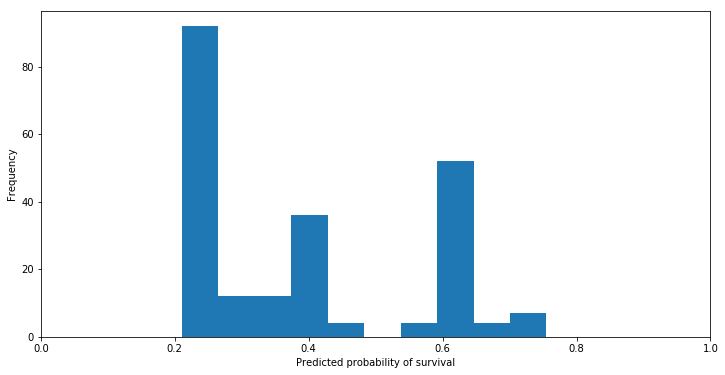

In [11]:
# store the predicted probabilities
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
predicted_probability = logreg.predict_proba(X_test)[:, 1]

# histogram of predicted probabilities
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)

plt.hist(y_pred_prob)
plt.xlim(0, 1)
plt.xlabel('Predicted probability of survival')
plt.ylabel('Frequency');

In [12]:
# Prdicted Class based on Predicted Probability
df = pd.DataFrame({'Predicted Class': predicted_class, 'Predicted Probability': predicted_probability})  
df.head()

,Predicted Class,Predicted Probability
0,1,0.608647
1,0,0.210461
2,0,0.391679
3,0,0.210461
4,1,0.560828


In [14]:
# Logistic Regression converst probability into class. By default greater than 50% is taken as 1 else 0
# Let's test this theory
import numpy as np
y_pred_class = np.where(y_pred_prob > 0.5, 1, 0)

# old confusion matrix
print('Original Confusion Matrix: \n', confusion)

# new confusion matrix
print('\nNew Confusion Matrix: \n', metrics.confusion_matrix(y_test, y_pred_class))

Original Confusion Matrix: 
 [[105  23]
 [ 51  44]]

New Confusion Matrix: 
 [[105  23]
 [ 51  44]]


In [15]:
# increase sensitivity i.e. positive rate by lowering the threshold for predicting survival
y_pred_class = np.where(y_pred_prob > 0.3, 1, 0)

# old confusion matrix
print('First Confusion Matrix: \n', confusion)

# new confusion matrix
print('\nNew Confusion Matrix: \n', metrics.confusion_matrix(y_test, y_pred_class))

First Confusion Matrix: 
 [[105  23]
 [ 51  44]]

New Confusion Matrix: 
 [[72 56]
 [32 63]]


In [16]:
# save confusion matrix and slice into four pieces
new_confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = new_confusion[1][1]
TN = new_confusion[0][0]
FP = new_confusion[0][1]
FN = new_confusion[1][0]

In [17]:
# new sensitivity (higher than before)
print('New Sensitivity: ', TP / float(TP + FN))

# new specificity (lower than before)# new sp 
print('New Specifivity: ', TN / float(TN + FP))

New Sensitivity:  0.663157894737
New Specifivity:  0.5625
